In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sb 
import shap
import sweetviz as sv

Load data

In [6]:
df = pd.read_excel(f'../data/Trader Analysis.xlsx')

In [7]:
df.head()

,Trader_ID,sum_amount_trades,sum_number_trades,tradingdays_trades,duration_trades,frequency_trades,trades_per_day_trades,net_loss_trades,percent_lost_trades
0,anon_S0,2.313,1.000,1.000,1.000,1.000,1.000,148.554,3.000
1,anon_S1,4.899,2.449,1.414,2.646,0.535,1.732,148.453,2.640
2,anon_S2,33.437,4.899,3.873,40.311,0.096,1.265,150.002,2.897
3,anon_S3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,anon_S4,3.240,3.464,2.449,46.829,0.052,1.414,148.502,2.653


In [8]:
df.describe()

,sum_amount_trades,sum_number_trades,tradingdays_trades,duration_trades,frequency_trades,trades_per_day_trades,net_loss_trades,percent_lost_trades
count,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000,1806.000000
mean,31.122340,7.670112,2.891851,10.451363,0.314914,1.322380,100.847070,1.900439
std,131.387692,20.183783,4.539190,13.347955,0.355016,1.264997,73.569949,1.355767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.280000,2.236000,1.414000,2.646000,0.175500,1.307500,148.539000,2.832000
75%,14.088750,6.982000,3.606000,19.079000,0.523500,2.000000,148.624000,2.869000
max,1490.008000,237.259000,36.606000,53.470000,1.000000,10.630000,371.478000,3.000000


1806 rows, 8 variables, no missing values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trader_ID              1806 non-null   object 
 1   sum_amount_trades      1806 non-null   float64
 2   sum_number_trades      1806 non-null   float64
 3   tradingdays_trades     1806 non-null   float64
 4   duration_trades        1806 non-null   float64
 5   frequency_trades       1806 non-null   float64
 6   trades_per_day_trades  1806 non-null   float64
 7   net_loss_trades        1806 non-null   float64
 8   percent_lost_trades    1806 non-null   float64
dtypes: float64(8), object(1)
memory usage: 127.1+ KB


In [10]:
df_features = df.drop(['Trader_ID'], axis=1)

Fit Isolation Forest with threshold of 1% data points as anomalies

In [11]:
# Train Isolation Forest model
model = IsolationForest(contamination=0.01,  random_state = 42) #1% as anomalies
df['anomaly_classify'] = model.fit_predict(df_features)
df['anomaly_score'] = model.score_samples(df_features)

In [12]:
# Identify anomalies
anomalies = df[df['anomaly_classify'] == -1]
print(f'Number of anomalies detected: {len(anomalies)}')

Number of anomalies detected: 19


In [13]:
df['anomaly_classify'].value_counts(normalize = True)

anomaly_classify
 1    0.98948
-1    0.01052
Name: proportion, dtype: float64

Visualize anomalies to inteprete insights

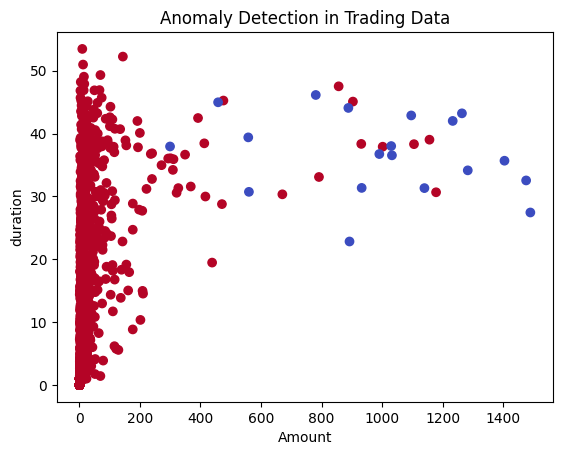

In [14]:
# Visualize anomalies
plt.scatter(df['sum_amount_trades'], df['duration_trades'], c=df['anomaly_classify'], cmap='coolwarm')
plt.xlabel('Amount')
plt.ylabel('duration')
plt.title('Anomaly Detection in Trading Data')
plt.show()

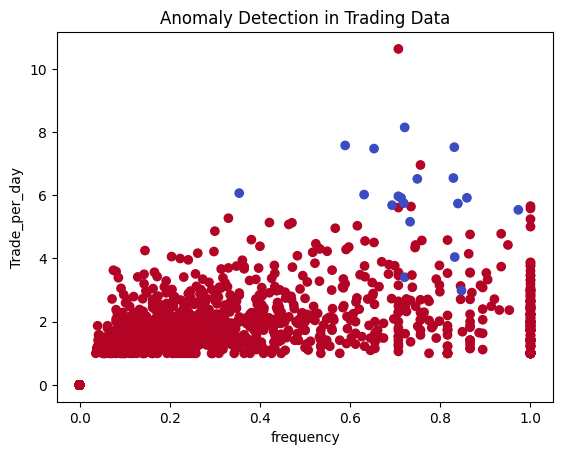

In [15]:
# Visualize anomalies
plt.scatter(df['frequency_trades'], df['trades_per_day_trades'], c=df['anomaly_classify'], cmap='coolwarm')
plt.xlabel('frequency')
plt.ylabel('Trade_per_day')
plt.title('Anomaly Detection in Trading Data')
plt.show()

Feature importance & inteprete value of 1 anomalies

In [16]:
exp = shap.TreeExplainer(model) #Explainer
shap_values = exp.shap_values(df_features)  #Calculate SHAP values
shap.initjs()

Interprete Shapley value: value of percent_lost_trades range between high but not too high leads to anomalies 
High value of duraction trade leads to anomalies and low value leads to normal. 

In [17]:
df[df['anomaly_classify']==-1].describe()

,sum_amount_trades,sum_number_trades,tradingdays_trades,duration_trades,frequency_trades,trades_per_day_trades,net_loss_trades,percent_lost_trades,anomaly_classify,anomaly_score
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000
mean,990.049474,155.348737,26.852263,36.735895,0.736474,5.894789,261.952579,2.840368,-1.0,-0.744395
std,342.685348,43.841702,6.124685,6.359338,0.131381,1.348751,66.234818,0.007826,0.0,0.013583
min,299.350000,94.779000,15.620000,22.825000,0.354000,2.986000,57.248000,2.827000,-1.0,-0.773800
25%,834.767500,123.642500,22.494000,31.947500,0.700000,5.613000,242.897500,2.835000,-1.0,-0.753803
50%,1030.182000,147.635000,26.944000,36.742000,0.721000,5.919000,271.485000,2.838000,-1.0,-0.745837
75%,1248.664500,189.352000,31.223500,42.448000,0.831500,6.532500,300.015500,2.845000,-1.0,-0.733364
max,1490.008000,237.259000,36.606000,46.141000,0.973000,8.148000,341.578000,2.854000,-1.0,-0.723608


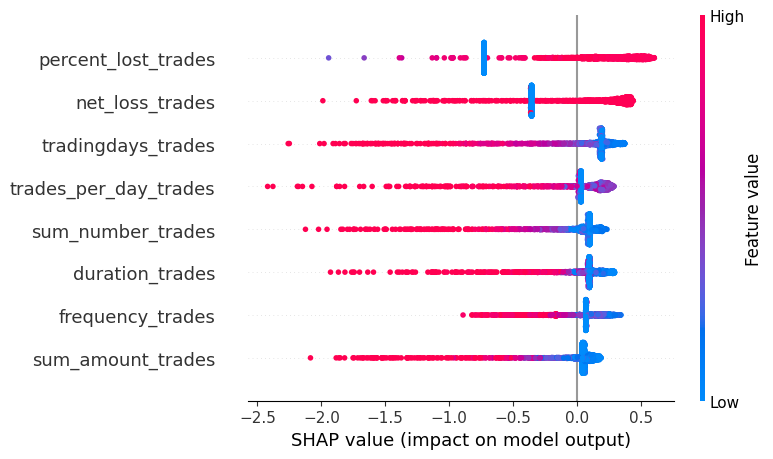

In [18]:
shap.summary_plot(shap_values, df_features)

Global Machine Learning interpretability 
* Contribution of each feature to detect anomalies sorting in order from largest to smallest: percent_lost_trades --> net_loss_trades --> duraction_trades...

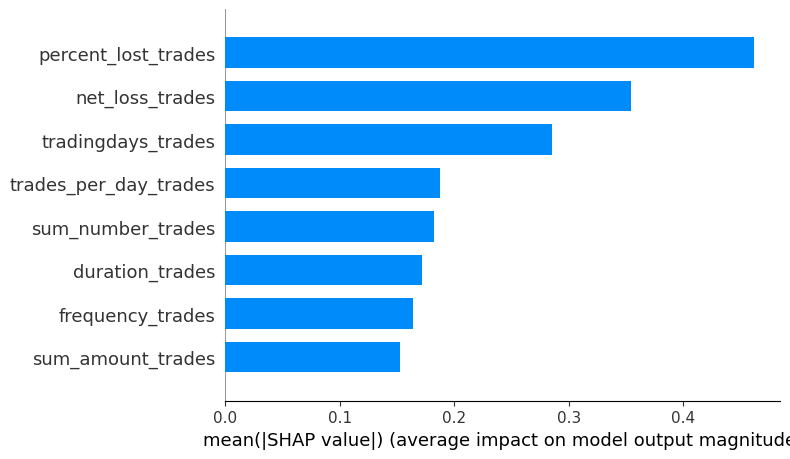

In [19]:
shap.summary_plot(shap_values, df_features,plot_type="bar")

Local data point interprete
* index 409th, 1782th etc are detected as anomalies. We will inteprete these samples

In [20]:
df[df['anomaly_classify']==-1].head()

,Trader_ID,sum_amount_trades,sum_number_trades,tradingdays_trades,duration_trades,frequency_trades,trades_per_day_trades,net_loss_trades,percent_lost_trades,anomaly_classify,anomaly_score
409,anon_S409,1233.427,227.893,34.814,42.012,0.829,6.546,289.210,2.836,-1,-0.764950
1782,anon_S1782,780.947,194.707,32.909,46.141,0.713,5.917,332.387,2.854,-1,-0.773800
1783,anon_S1783,888.588,94.779,15.620,44.079,0.354,6.068,271.485,2.840,-1,-0.732038
1785,anon_S1785,458.165,219.536,29.360,44.978,0.653,7.477,197.602,2.843,-1,-0.755180
1786,anon_S1786,932.595,159.480,26.944,31.353,0.859,5.919,310.821,2.844,-1,-0.755998


In [21]:
shap.force_plot(exp.expected_value, shap_values[409],features =df_features.iloc[409,:] ,feature_names =df_features.columns)

sum_number_trades, tradingdays_trades, sum_amount_trades, net_loss_trades are pushing the outcome towards being an anomaly.
This point does not follow the global pattern

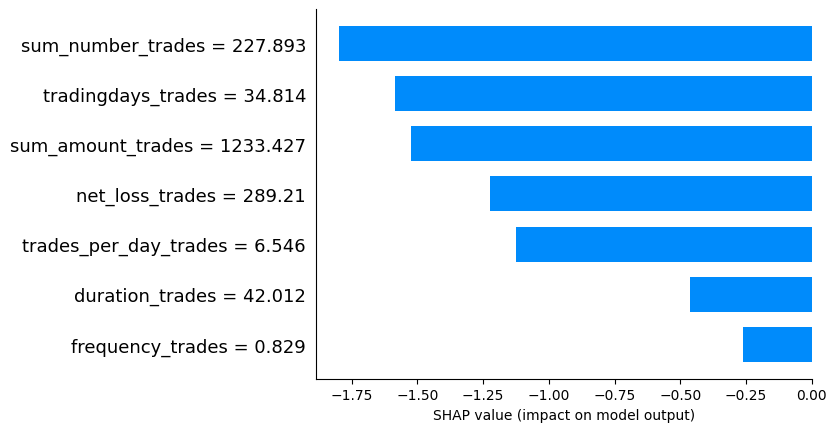

In [22]:
shap.bar_plot(shap_values[409],features = df_features.iloc[409,:] ,feature_names =df_features.columns )

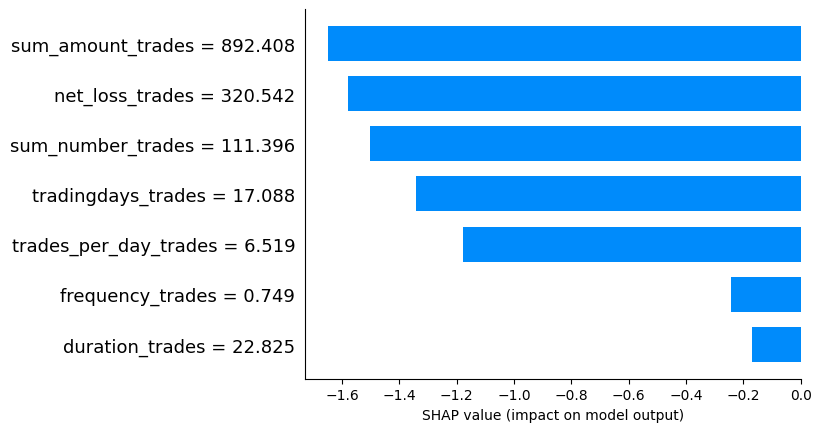

In [23]:
shap.bar_plot(shap_values[1804],features = df_features.iloc[1804,:] ,feature_names =df_features.columns )

Also i generate sweetviz EDA report to better understand the anomaly points. Click to Report.html file to see result in browser

Anomalous trader owns characters: 
* percent_lost_trades approximately 3
* net_loss_trades over 200
* trade_per_day_trades over 5
* frequency_trades in range (0.3,0.9)
* duration_trades in range (22,46)
* tradingdays_trades over 12
* sum_number_trades over 60
* sum_amount_trades in range (300,400) or over 800

In [24]:
feature_config = sv.FeatureConfig(skip=['Trader_ID', 'anomaly_score'], force_num=["anomaly_classify"])

In [25]:
report = sv.analyze(df, target_feat='anomaly_classify', feat_cfg = feature_config)

                                             |          | [  0%]   00:00 -> (? left)